# Sensordata fra Garmin løpeklokke: Lineær regresjon

Datasettet `garmindata.csv` har vi lastet ned fra en personlig brukerkonto på connect.garmin.com. Vi har allerede studert dette datasettet i notatboken garmindata.ipynb (beskrivende statistikk), og vi skal nå bruke det samme datasettet for å tilpasse lineære regresjonsmodeller. Denne gangen henter vi inn et ferdig redigert datasett (kolonnenavn på ønsket format og uteligger er fjernet).

Vi skal studere sammenhengen mellom distanse og tid på løpeturer, og i tillegg høydemeter og kaloriforbruk. 

## Læringsmål: Linær regresjon

### Delmål
1. Tilpasse en regresjonsmodell til data og lese ut resultater fra analysen
2. Konfidensintervall for regresjonslinja
3. Usikkerhet forbundet med prediksjoner
4. Hvor god er modellen ($R^2$)?
5. Residualer og sjekk av modellantagelsene

## Motivasjon

### Lineær regresjon og modellantagelser

Vi lar distansen (i km) på en løpetur være en forklaringsvariabel, $x$, (også kalt kovariat), mens tidsbruk (i minutter) er en responsvariabel, $Y$. Vi antar at tiden det tar å løpe en viss distanse er en normalfordelt størrelse der forventningsverdien er lineær i $x$, beskrevet at regresjonslinja $\beta_0 + \beta_1 x$, og der variasjonen er den samme uansett distanse: 

$$Y|X=x \sim N(\beta_0 + \beta_1 x, \sigma)$$

Vi antar videre at observasjonsparene $(x_1, Y_1), \ldots, (x_{55}, Y_{55})$ er uavhengige. Denne antagalsen innebærer at hvis du *vet* at joggeren løp $x_i$ km på $y_i$ minutter på dag $i$, så gir det deg ikke noe tilleggsinformasjon når det kommer til å modellere tiden $Y_{j}$ på en annen løpetur (som var på $x_{j}$ km).

**Merk:** Her kommer du til å få repetert metoder fra 
- beskrivende statistikk (uke 1), 
- estimering og konfidensintervall i normalfordeling (uke 7), og 
- hypotesetester (uke 8)

## Steg 1: Laste inn nødvendige python-pakker

In [62]:
import pandas as pd # lese data fra csv-fil og bruke DataFrames
import seaborn as sns # plotting
sns.set(style = 'whitegrid', font_scale = 1.5) # utseende av plott
import matplotlib.pyplot as plt # mer plotting
import numpy as np # matematikk
import statsmodels.api as sms # regresjonen
import statsmodels.formula.api as smf # formel for regresjonen

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)# fordi en av plottefunksjonene må oppdateres av utvikler og kommer per i dag med lang FutureWarning som vi ikke vil se på

## Steg 2: Lese inn data (repetisjon)

In [47]:
df = pd.read_csv('https://www.math.ntnu.no/emner/IST100x/python_felles/garmindata2.csv')
df.shape # dimenensjonen til datasettet

(55, 32)

In [13]:
print(df.columns) # Alle kolonnenavn

Index(['Activity_Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg_HR', 'Max_HR', 'Aerobic_TE', 'Avg_Run_Cadence',
       'Max_Run_Cadence', 'Avg_Pace', 'Best_Pace', 'Elev_Gain', 'Elev_Loss',
       'Avg_Stride_Length', 'Avg_Vertical_Ratio', 'Avg_Vertical_Oscillation',
       'Training_Stress_Score_', 'Grit', 'Flow', 'Climb_Time', 'Bottom_Time',
       'Min_Temp', 'Surface_Interval', 'Decompression', 'Best_Lap_Time',
       'Number_of_Laps', 'Max_Temp', 'TimeMin', 'Hastighet'],
      dtype='object')


## Steg 2: Beskrivende statistikk

Vi er hovedsakelig er interessert i sammenhengen mellom *tid og distanse* og gjør beskrivende statistikk på disse observasjonene. 

### Gjennomsnitt og standardavvik

In [57]:
gjsnitt_dist = sum(df['Distance'])/55
avvik = [(x - gjsnitt_dist) ** 2 for x in df['Distance']]
sd_dist = np.sqrt(sum(avvik)/54)

print("Gjennomsnittlig distanse:", round(gjsnitt_dist,2), "km")
print("Standardavvik distanse:", round(sd_dist,2), "km")

Gjennomsnittlig distanse: 5.21 km
Standardavvik distanse: 1.36 km


In [58]:
gjsnitt_tid = sum(df['TimeMin'])/55
avvik_tid = [(x - gjsnitt_tid) ** 2 for x in df['TimeMin']]
sd_tid = np.sqrt(sum(avvik_tid)/54)
var_tid = sum(avvik_tid)/54

print("Gjennomsnittlig tid:", round(gjsnitt_tid,2), "min")
print("Standardavvik tid:", round(sd_tid,2), "min")
print("Varians tid:", round(var_tid,2))

Gjennomsnittlig tid: 31.06 min
Standardavvik tid: 7.94 min
Varians tid: 63.1


### Histogrammer og boksplott

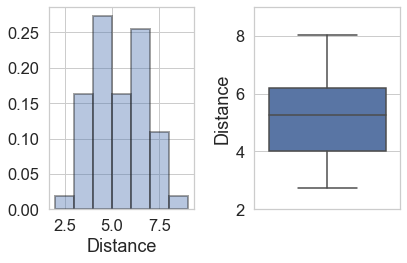

In [68]:
plt.subplot(1, 2, 1)
sns.distplot(df['Distance'], bins = range(2, 10), 
             kde = False, hist_kws=dict(edgecolor="k", linewidth=2),
            norm_hist=True)

plt.subplot(1, 2, 2)
sns.boxplot(y='Distance',data=df)
plt.ylim(2, 9)

plt.tight_layout()
plt.show()

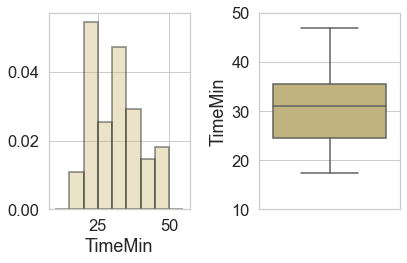

In [73]:
plt.subplot(1, 2, 1)

sns.distplot(df['TimeMin'], bins = np.arange(10, 60, 5).tolist(), 
             kde = False, hist_kws=dict(edgecolor="k", linewidth=2),
            color = 'y', norm_hist=True)

plt.subplot(1, 2, 2)
sns.boxplot(y='TimeMin',data=df,color='y')
plt.ylim(10, 50)

plt.tight_layout()
plt.show()

**Kommentar**: Vi observerer at observasjonene og tid og distanse er relativt symmetriske, men der en viss overvekt av korte turer mellom 20 og 25 minutter.

**NB!**: Vi har *ikke* antatt at distanse eller tid er normalfordelte størrelser hver for seg. Antagelsen vår er at tid, betinget på distanse, er normalfordelt. Derfor skal vi ikke bruke disse figurene til å kommentere normalfordeling, men det er greit å vite noe om hvordan observasjoner av tid og distanse ser ut.

### Kryssplott / Spredningsplott

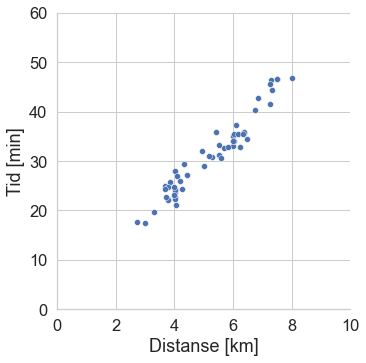

In [72]:
# Plotter tid mot distanse for å få et inntrykk av datasettet

sns.relplot(x='Distance', y='TimeMin',data = df)
plt.xlim(0,10); plt.ylim(0,60)
plt.ylabel('Tid [min]'); plt.xlabel('Distanse [km]')
plt.show()

### Kovarians og korrelasjon

In [67]:
hat_cov = sum(np.multiply([(x - gjsnitt_dist) for x in df['Distance']],[(y - gjsnitt_tid) for y in df['Ti']]))/54
print("Estimert kovarians:", round(hat_cov,2))

r = hat_cov/(sd_dist*sd_tid)
print("Estimert (empirisk) korrelasjon:", round(r,2))

Estimert kovarians: 10.49
Estimert (empirisk) korrelasjon: 0.97


**Kommentar:** Vi observerer korrelasjon $R=0.97$ mellom tid og distanse. Hva betyr det? Som vi også ser fra figur så er det tydelig at det er en *lineær* sammenheng mellom tid og distanse, og derfor blir kovarians og korrelasjon ulik 0. Sammenheng mellom tid og distanse er positiv (lengre distanse, mer tid), og derfor er kovarians og korrelasjon positive tall. 
I tillegg ser vi fra figuren at det lite annet "støy". Litt uformelt vil det si at dersom vi *vet* hvilken verdi den ene variabelen tar, så skal vi klare å gjette ganske så presist hvilken verdi den andre variabelen kommer til å ta. Da får vi en korrelasjon som nesten er lik 1. 

## Steg 3: Korrelasjon (repetisjon)

In [18]:
# Regne ut korrelasjon (med Pandas)
round(df['Distance'].corr(df['TimeMin']),3)

0.969

## Steg 4: Tilpasse en lineær regresjonsmodell

In [38]:
modell = smf.ols('TimeMin~Distance', data=df).fit()

# Merk: I video brukes denne metoden: (gir akkurat samme resultat)
# X = df[['Distanse']]    # Bestemme kovariat x
# X = sms.add_constant(X) # Legge til konstant for å ha med konstantledd beta_0 i modellen
# y = df['Tid']           # Bestemme responsvariabel y
# modell = sms.OLS(y, X).fit()

modell.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TimeMin   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     828.4
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           4.97e-34
Time:                        10:07:17   Log-Likelihood:                -114.21
No. Observations:                  55   AIC:                             232.4
Df Residuals:                      53   BIC:                             236.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6002      1.057      1.513      0.136      -0.521       3.721
Distance       5.6524      0.196     28.782      0.000       5.258       6.046
==============================================================================
Omnibus:                        2.116   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.499
Skew:                           0.181   Prob(JB):                        0.473
Kurtosis:                       2.277   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lese av estimert regresjonslinje

Vi kan lese at estimert linje er $\hat{y}_i = 1.6003 + 5.6525 x_i$. Regresjonslinja er plottet i figuren under. Estimatet av linja innebærer at *estimert* forventet tid på en 5-km løpetur, $\hat{\text{E}}(Y|X=5) = 29.86$ minutter. Det vi si at dersom joggeren løper 5 km veldig mange ganger, så tror vi at *gjennomsnittstiden* av alle disse løpeturene vil bli på 29.86 minutter.

Vi kan også lese ut testobservatoren $t = 28.782$ (og $p$-verdien som, pga avrunding til 3 desimaler, tydeligvis er mindre enn $0.0005$) for en hypotesetest på stigningstallet ($H_0: \beta_1 = 0$, mot $H_1: \beta_1 \neq 0$), samt et 95% konfidensintervall $[5.259, 6.046]$ på stigningstallet. 

### Plotte estimert regresjonslinje

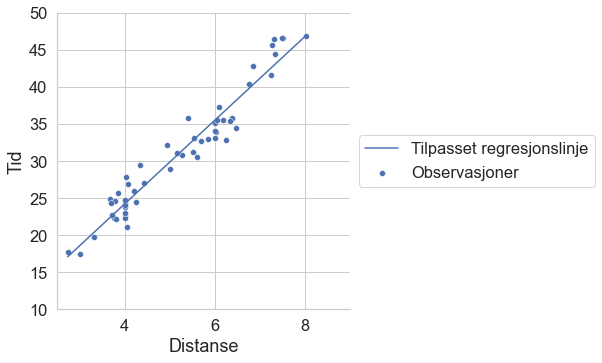

In [28]:
predres = modell.get_prediction().summary_frame(alpha = 0.05)  # Estimert forventningsverdi, prediksjon og intervaller
df_pred = pd.concat([df[["Distance","TimeMin"]], predres], axis=1)

sns.relplot(x="Distance", y="TimeMin",data = df_pred, label="Observasjoner")
sns.lineplot(x='Distance', y='mean', data = df_pred, label = "Tilpasset regresjonslinje")

plt.ylim(10, 50); plt.xlim(2.5, 9); plt.ylabel("Tid"); plt.xlabel("Distanse")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Hvor god er modellen? $R^2$

I sammendraget kan vi også lese av mål på hvor god modellen er: $R^2 = 0.940$, der $R^2$ er kvadratet av korrelasjonen som vi regnet ut tidligere. $R^2$ forteller oss hvor mye variasjon i respons-variabelen (tid) som forklares av regresjonsmodellen. 

I koden under regner vi ut at empirisk varians i observasjonene av tid på løpeturer er 63.1. Variansen i tid sier noe om spredningen av observasjoner rundt gjennomsnittet. 

Etter at vi har tilpasset regresjonsmodellen kan vi estimere variansen i tid *betinget på* distanse. Det vil si spredning av observasjoner over og under regresjonslinja. Som vi allerede kan se fra kryssplottet av tid og distanse, er det lite spredning rundt linja (høy korrelasjon) og varians i tid 'rundt' linja er 3.87.

In [42]:
round(np.var(df['TimeMin'], ddof = 1),2) # varians i tid

63.1

In [41]:
round(modell.mse_resid,2) # varians i tid 'rundt' regresjonslinja

3.87

Vi startet altså med en (total) varians i tid på 63.1, men etter å ha tilpasset en modell for tid betinget på distanse, sitter vi igjen med en varians på 3.87. Andelen varians i tid som ennå ikke har blitt "forklart" er omtrent $\frac{3.87}{63.1} = 0.06$, mens den andelen av variansen som har blitt forklart med regresjonsmodellen, $R^2$, er omtrent $\frac{63.1 - 3.87}{63.1} = 1 -  \frac{3.87}{63.1} = 0.94$.

### Konfidensintervall for regresjonslinja

Litt lengre opp på siden hentet vi ut estimatet for linja ved en funksjon `modell.get_prediction().summary_frame(alpha = 0.05)`. Denne funksjonen gir oss også et konfidensintervall for linja. Siden vi har valgt $\alpha = 0.05$ får vi ut et 95% konfidensintervall på regresjonslinja som er plottet under.

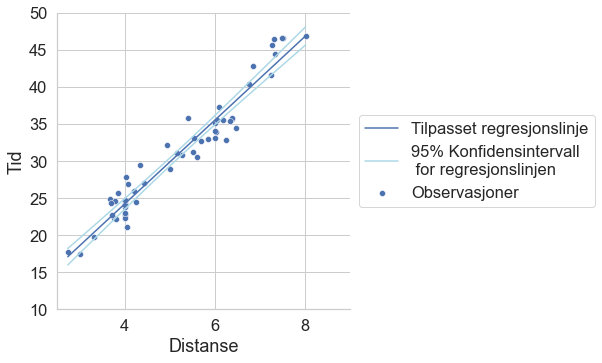

In [43]:
sns.relplot(x='Distance', y='TimeMin',data = df_pred, label="Observasjoner")
sns.lineplot(x='Distance', y='mean', data = df_pred, label = "Tilpasset regresjonslinje")

sns.lineplot(x='Distance', y='mean_ci_lower', data = df_pred, color = "lightblue",label = "95% Konfidensintervall \n for regresjonslinjen")
sns.lineplot(x='Distance', y='mean_ci_upper', data = df_pred, color = "lightblue")

plt.ylim(10, 50); plt.xlim(2.5, 9); plt.ylabel("Tid"); plt.xlabel("Distanse")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Konfidensintervallet på linja viser hvor vi med rimelig stor sikkerhet tror at regresjonslinja ligger. Alle rette linjer som vi kan plassere innenfor konfidensintervallet, er rimelige estimater på $E(Y|X=x) = \beta_0 + \beta_1 x$.  Vi ser at vi kan dytte *litt* på den tilpassede regresjonslinja og likevel holde oss innenfor intervallet. Intervallet reflekterer usikkerheten i estimatet av linja, og her ser vi at det generelt er lite usikkerhet, spesielt i "midten" av datasettet. 

## Prediksjoner basert på den lineære regresjonsmodellen

Når det gjelder å *predikere* tiden joggeren bruker dersom hun i morgen løper 5 km (én løpetur), så gjetter vi på $\hat{\beta}_0 + \hat{\beta}_1 \cdot 5$, som er lik 29.86 minutter, altså estimatet av regresjonslinja. 

Kan vi predikere tiden joggeren bruker på 10 km? $\hat{\beta}_0 + \hat{\beta}_1 \cdot 10 = 58.13$ min? Kan vi predikere tiden joggeren bruker på et maraton? $\hat{\beta}_0 + \hat{\beta}_1 \cdot 42.195 = 240.12$ min $= 4$ timer? Generelt skal vi være forsiktige med å gjøre prediksjoner langt utenfor området av datasettet. Siden joggeren ikke har en eneste løpetur over 10 min i datasettet så må vi spørre oss om hun i det hele tatt er i stand til å løpe et helt maraton?

### Prediksjonsintervall 

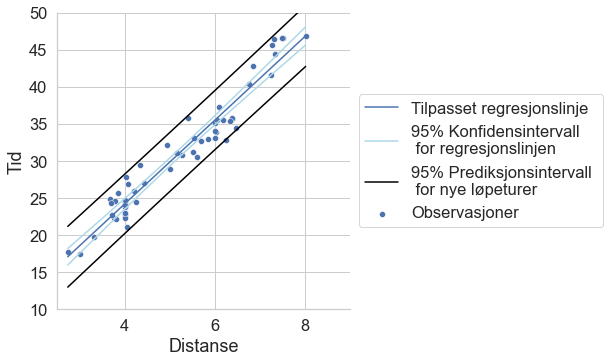

In [32]:
sns.relplot(x='Distance', y='TimeMin',data = df_pred, label="Observasjoner")
sns.lineplot(x='Distance', y='mean', data = df_pred, label = "Tilpasset regresjonslinje")

sns.lineplot(x='Distance', y='mean_ci_lower', data = df_pred, color = "lightblue",label = "95% Konfidensintervall \n for regresjonslinjen")
sns.lineplot(x='Distance', y='mean_ci_upper', data = df_pred, color = "lightblue")

sns.lineplot(x='Distance', y='obs_ci_lower', data = df_pred, color = "black",label = "95% Prediksjonsintervall \n for nye løpeturer")
sns.lineplot(x='Distance', y='obs_ci_upper', data = df_pred, color = "black")

plt.ylim(10, 50); plt.xlim(2.5, 9); plt.ylabel("Tid"); plt.xlabel("Distanse")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

I figuren over har vi plottet prediksjonsintervaller for nye løpeturer. Dersom joggeren skal løpe 5 km i morgen, hvor lang tid vil du gjette på at hun kommer til å bruke? Hvis du bare skal gi ett tall, så bruker du den tilpassede regresjonslinja. Tilpasningen av linja er jo forbundet med usikkerhet (som reflekteres av konfidensintervallet for linja). I tillegg er utfallet av hver enkelt løpetur forbundet med usikkerhet, siden $Y|X=x$ er en stokastisk variabel med estimert standardavvik på $\sqrt{3.87} \approx 1.97$ minutter. Når vi tar hensyn til begge disse kildene til usikkerhet *samtidig*, så kan vi regne ut prediksjonsintervaller slik som vist i figuren.

## Modellsjekk med residualplott

For å sjekke modellantagelser er det vanlig å plotte det som kalles residualer. Og, for å forstå hva residualer er, er det lurt å tenke på regresjonsmodellen på følgende måte: 
$$ Y = \beta_0 + \beta_1 x + e, \quad e \sim N(0, \sigma) $$

Vi definerer altså $Y$ (*tid* i vårt eksempel) som en sum av to ledd. Det første leddet er regresjonslinja $\beta_0 + \beta_1 x$. Dette leddet er ikke stokastisk, men kan variere ettersom vi varier $x$ (*distanse* i vårt eksempel). Det andre leddet, $e$, kalles et *feilledd*, og $e$ er en normalfordelt stokastisk variabel med forventning 0 og standardavvik $\sigma$. Siden $Y$ her er definert som en konstant pluss en normalfordelt stokastisk variabel så er $Y \sim N(\beta_0 + \beta_1x, \sigma)$, akkurat som vi har antatt frem til nå. Denne måten å skrive regresjonsmodellen på fremhever skillet mellom regresjonslinja, $\beta_0 + \beta_1 x$, og de stokastiske avvikene over og under linja, $e \sim N(0, \sigma)$. Når vi har et tilfeldig utvalg antar vi at feilledene $e_1, e_2, \ldots, e_n$ er uavhengige.

Etter å ha tilpasset regresjonsmodellen kan vi regne ut *residualene* $$\hat{e}_i = y_i - (\hat{\beta}_0 + \hat{\beta}_1 x_i),$$ som rett og slett er estimater av tallverdien av feilleddene $e_i$, $i = 1, \ldots, n$.

For å sjekke om modellantagelsene er tilfredsstilt så bør residualene se ut til å være realisasjoner av uavhengige og normalfordelte stokastiske variabler med forventning $0$ og alle med samme varians/standardavvik. 

### Er forholdet mellom respons $Y$ og kovariat $x$ lineært, og er variansen den samme for alle verdier av kovariaten $x$?

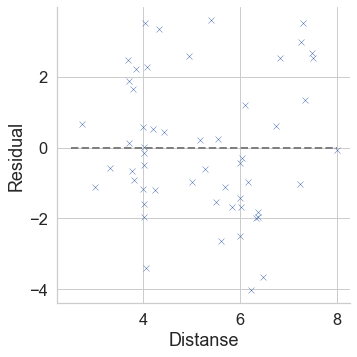

In [44]:
df_resid = pd.DataFrame({"Distanse": df["Distance"], "Residual": modell.resid} ) 
sns.relplot(x='Distanse', y="Residual",data = df_resid,marker="x")
plt.plot([2.5, 8], [0, 0], color = "grey",linewidth=2, linestyle = "--")
plt.show()

Her har vi plottet residualene $\hat{e}_i$ mot kovariaten $x_i$ i regresjonsmodellen. En av antagelsene i regresjonsmodellen er at responsvariabelen $Y$ tar verdier over og under regresjonslina $\beta_0 + \beta_1 x$ ifølge en normalfordeling med standardavvik $\sigma$ der standardavviket er det samme uansett hvilken verdi $x$ tar. En annen måte å fremstille denne antagelsen på er at feilledenne $e_i$ er normalfordelte med forventning 0 og med samme standardavvik $\sigma$. For å sjekke denne antagelsen kan vi sjekke at residualene $\hat{e}_i$ ser ut til å være tilfeldig trukket fra en fordeling med forventning 0 og samme standardavvik for alle $x_i$. 

Vi burde bekymre oss dersom det så ut til å være en trend i figuren (kanskje forholdet mellom $y$ og $x$ ikke er lineært?) eller dersom variansen/spredning av residualene ikke så ut til å være lik overalt. 

### Normalfordelt respons (feilledd)?

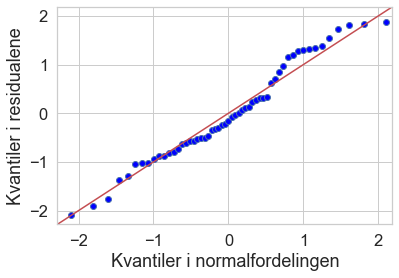

In [35]:
sms.qqplot(modell.resid,line='45',fit=True)
plt.ylabel("Kvantiler i residualene")
plt.xlabel("Kvantiler i normalfordelingen")
plt.show()

Her har vi plottet det som kalles et QQ-plott. Vi plotter kvantiler i residualene (1% laveste, 5% laveste, 10% laveste, median osv.) mot teoretiske kvantiler i normalfordelingen. Dersom kvantilene legger seg på en rett linje, ser antagelsen om normalfordelte feilledd $e \sim N(0,\sigma)$ (og dermed $Y|X=x$ normalfordelt) ut til å stemme. 

### Er observasjonene uavhengige?

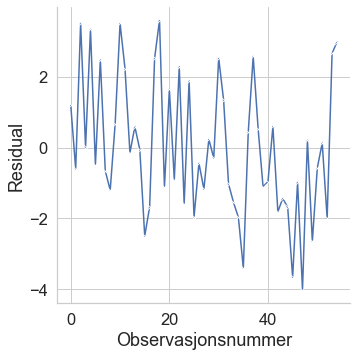

In [46]:
df_resid['Observasjonsnummer'] = df_resid.index
sns.relplot(x='Observasjonsnummer', y="Residual",
            data = df_resid,marker="x", kind="line")
plt.show()

Generelt er det ikke enkelt å se på dataene om observasjonene våre er uavhengige. Kanskje må vi samle inn data på en slik måte at vi sikrer uavhengighet mellom observasjoenen. I dette eksempelet er *målingene* gjort over tid, fra juni 2020 til oktober 2020. Når vi plotter residualene i mot observasjonsnummer kan vi se etter eventuelle trender i tid. Her kan det kanskje se ut som om løpstidene til joggeren har forbedret seg fra juni til august. Det vil bety at tiden som ble brukt på løpetur nr $i$ til en viss grad avhenger av de løpeturene som har blitt gjort før, og det bryter med antagelsen om uavhengighet. Det bør vi ha i bakhodet dersom vi vil gjøre prediksjoner fremover i tid. I mer viderkomne statistikk-kurs kan du lære om *tidsrekkemodeller*.

# Bonus: illustrasjon av datasett med lavere korrelasjon

## Kalori og høydemeter på løpeturer

I dette eksempelet skal vi bruke lineær regresjon for å modellere sammenhengen mellom antall høydemeter klatret i løpet av en joggetur og (estimert) kaloriforbruk. Merk at en løpeklokke ikke måler kaloriforbruk, så vi må anta at det finnes en algoritme som estimerer kaloriforbruk ved å ta i bruk en rekke forklaringsvariabler (tid, distanse, puls, etc.)

#### Hvorfor høydemeter som forklaringsvariabel?
Vi kan tenke oss at joggeturer med mange oppoverbakker er mer *krevende* enn de joggeturerne som går på flata. Vi ønsker å sjekke denne hypotesen ved å tilpasse en lineær regresjonsmodell mellom antall høydemeter og kaloriforbruk. 

#### Hva skal du se etter?
Ved å se på dette eksempelet *etter* at du har studert modellen for tid og distanse på løpeturer, kan du forstå mer av korrelasjon, $R$, og målet på hvor god modellen er, $R^2$, forteller oss. Det burde være åpenbart at antall høydemeter ikke vil være den eneste forklaringsvariabelen for kaloriforbruk, og dermed ser vi at den enkle regresjonsmodellen ikke klarer å forklare en særlig stor andel av variasjonen kaloriforbruk på løpeturer.

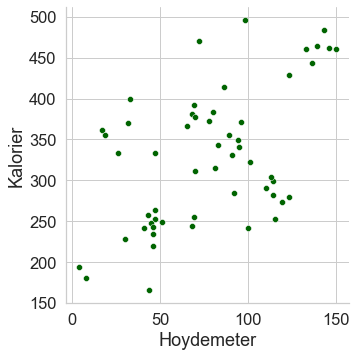

In [50]:
sns.relplot(x='Elev_Gain', y='Calories',data = df, color = "darkgreen")
plt.ylabel("Kalorier"); plt.xlabel("Hoydemeter")
plt.show()

In [51]:
modell = smf.ols('Calories~Elev_Gain', data=df).fit()

modell.summary()  # Merk R^2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Calories   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     20.52
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           3.39e-05
Time:                        10:25:58   Log-Likelihood:                -312.19
No. Observations:                  55   AIC:                             628.4
Df Residuals:                      53   BIC:                             632.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    237.4211     22.218     10.686      0.000     192.858     281.984
Elev_Gain      1.1676      0.258      4.530      0.000       0.651       1.685
==============================================================================
Omnibus:                        5.832   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                2.472
Skew:                           0.180   Prob(JB):                        0.291
Kurtosis:                       2.026   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

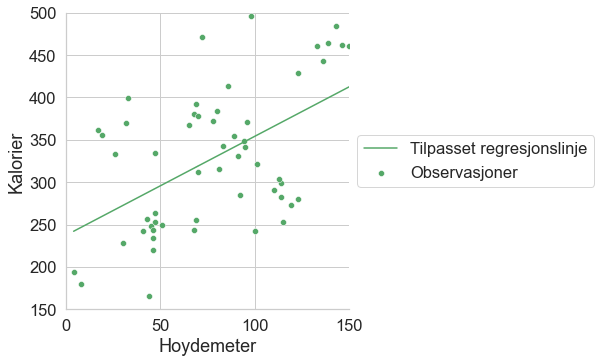

In [54]:
predres = modell.get_prediction().summary_frame(alpha = 0.05)
df_pred = pd.concat([df[["Elev_Gain","Calories"]], predres], axis=1)

sns.relplot(x="Elev_Gain", y="Calories",data = df_pred, color = "g", label="Observasjoner")
sns.lineplot(x='Elev_Gain', y='mean', data = df_pred, color = "g",label = "Tilpasset regresjonslinje")

plt.ylim(150, 500); plt.xlim(0, 150); plt.ylabel("Kalorier"); plt.xlabel("Hoydemeter")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

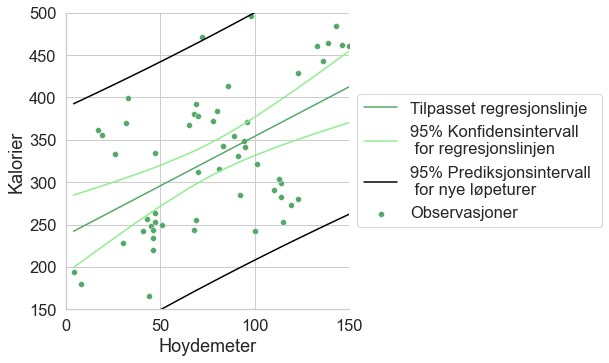

In [55]:
sns.relplot(x="Elev_Gain", y="Calories",data = df_pred, color = "g", label="Observasjoner")
sns.lineplot(x='Elev_Gain', y='mean', data = df_pred, color = "g",label = "Tilpasset regresjonslinje")

sns.lineplot(x='Elev_Gain', y='mean_ci_lower', data = df_pred, color = "lightgreen",label = "95% Konfidensintervall \n for regresjonslinjen")
sns.lineplot(x='Elev_Gain', y='mean_ci_upper', data = df_pred, color = "lightgreen")

sns.lineplot(x='Elev_Gain', y='obs_ci_lower', data = df_pred, color = "black",label = "95% Prediksjonsintervall \n for nye løpeturer")
sns.lineplot(x='Elev_Gain', y='obs_ci_upper', data = df_pred, color = "black")

plt.ylim(150, 500); plt.xlim(0, 150); plt.ylabel("Kalorier"); plt.xlabel("Hoydemeter")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()